In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 9
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((518, 12, 1), (518,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT9/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 510ms/step - loss: 0.2647 - root_mean_squared_error: 0.5145 - val_loss: 0.1718 - val_root_mean_squared_error: 0.4145
Epoch 2/50
53/53 [==============================] - 24s 471ms/step - loss: 0.0996 - root_mean_squared_error: 0.3156 - val_loss: 0.0736 - val_root_mean_squared_error: 0.2713
Epoch 3/50
53/53 [==============================] - 25s 476ms/step - loss: 0.0593 - root_mean_squared_error: 0.2435 - val_loss: 0.0510 - val_root_mean_squared_error: 0.2259
Epoch 4/50
53/53 [==============================] - 25s 484ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1762
Epoch 5/50
53/53 [==============================] - 25s 478ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 6/50
53/53 [==============================] - 26s 494ms/step - loss: 0.0210 - root_mean_squared_error: 0.1451 - val_loss: 0.0166 

Epoch 30/50
53/53 [==============================] - 26s 499ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 31/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 32/50
53/53 [==============================] - 26s 507ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 33/50
53/53 [==============================] - 4s 81ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 34/50
53/53 [==============================] - 4s 81ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 35/50
53/53 [==============================] - 4s 81ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0037 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

12.979167294502258 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

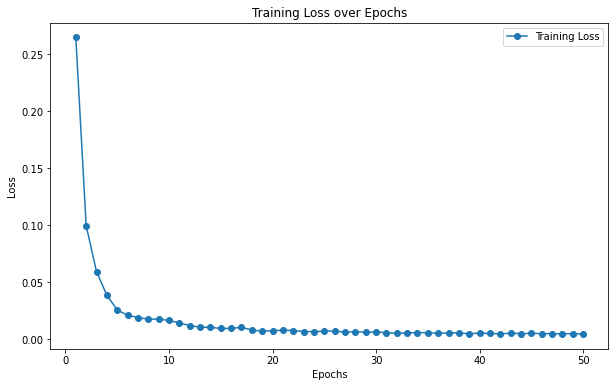

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

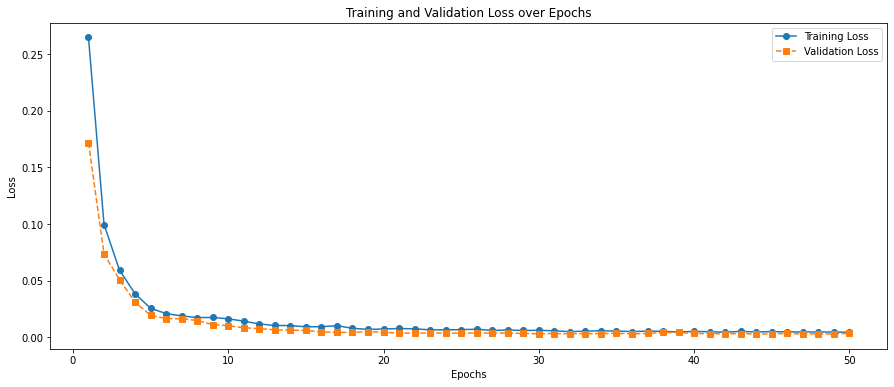

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT9/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 32ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0577017757903252
MAE : 0.04772712641209492


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.289691e+06,1633675.726
1,1.220770e+06,1292668.399
2,1.180819e+06,1527666.815
3,2.220763e+06,2121949.701
4,3.724265e+06,3562381.775
5,4.805263e+06,5004305.983
6,5.707502e+06,6176613.878
7,6.364526e+06,6794233.093
8,6.537536e+06,7024136.637
9,6.299395e+06,6554271.388


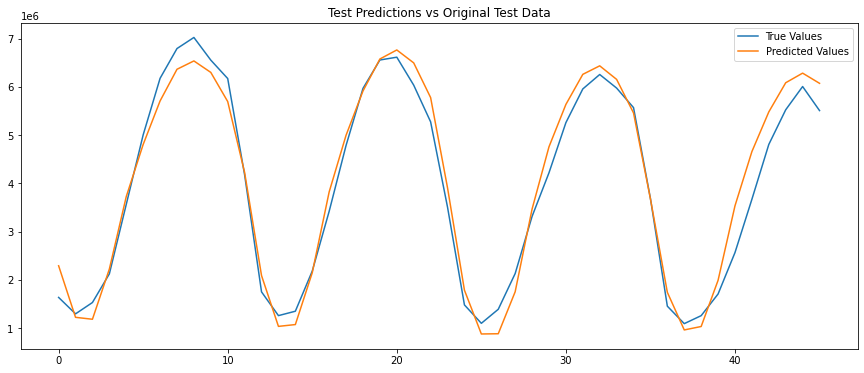

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 48ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

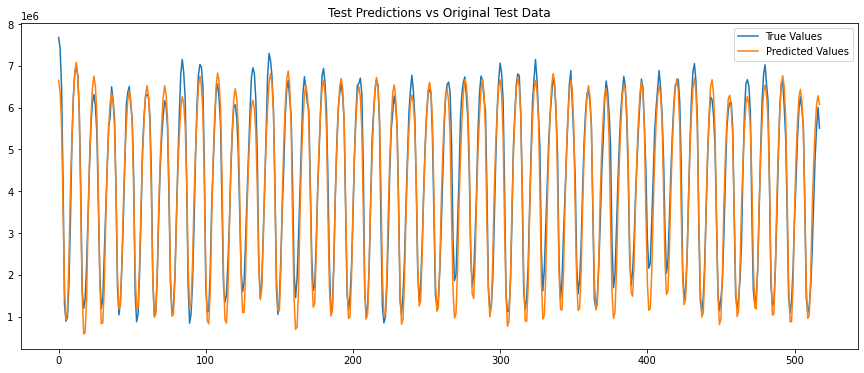

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()